In [1]:
import torch
import torch.nn as nn

seed = 1
torch.manual_seed(seed)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader



In [2]:
dataset_filepath = '/content/weatherHistory.csv'
df = pd.read_csv(dataset_filepath)

df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [3]:
univariate_df = df['Temperature (C)']
univariate_df.index = df['Formatted Date']
univariate_df.head()

,Temperature (C)
Formatted Date,
2006-04-01 00:00:00.000 +0200,9.472222
2006-04-01 01:00:00.000 +0200,9.355556
2006-04-01 02:00:00.000 +0200,9.377778
2006-04-01 03:00:00.000 +0200,8.288889
2006-04-01 04:00:00.000 +0200,8.755556


In [28]:
input_size = 6
label_size = 1
offset = 1

def slicing_window(df, df_start_idx, df_end_idx, input_size, label_size, offset):
  features = []
  labels = []

  window_size = input_size + offset

  if df_end_idx is None:
    df_end_idx = len(df) - window_size
  for idx in range(df_start_idx, df_end_idx):
    feature_end_idx = idx + input_size
    label_start_idx = idx + window_size - label_size

    feature = df[idx:feature_end_idx]
    label = df[label_start_idx:(idx+window_size)]

    features.append(feature)
    labels.append(label)

  features = np.expand_dims(np.array(features), -1)
  labels = np.array(labels)

  return features, labels

In [29]:
dataset_length = len(univariate_df)
train_size = 0.7
val_size = 0.2
train_end_idx = int(train_size * dataset_length)
val_end_idx = int(val_size * dataset_length) + train_end_idx

X_train, y_train = slicing_window(univariate_df, 0, train_end_idx, input_size, label_size, offset)

X_val, y_val = slicing_window(univariate_df, train_end_idx, val_end_idx, input_size, label_size, offset)

X_test, y_test = slicing_window(univariate_df, val_end_idx, None, input_size, label_size, offset)

In [30]:
class WeatherForeCast(Dataset):
  def __init__(
      self,
      X, y,
      transform=None,
  ):
    self.X = X
    self.y = y
    self.transform = transform
  def __len__(self):
    return len(self.X)
  def __getitem__(self, idx):
    X = self.X[idx]
    y = self.y[idx]

    if self.transform:
      X = self.transform(X)

    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)

    return X, y



In [31]:
train_dataset = WeatherForeCast(
    X_train, y_train
)

val_dataset = WeatherForeCast(
    X_val, y_val
)

test_dataset = WeatherForeCast(
    X_test, y_test
)

train_batch_size = 128
test_batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=test_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)



In [32]:
class WeatherForeCast(nn.Module):
  def __init__(self, embedding_dim, hidden_size, n_layers, dropout_prob):
    super(WeatherForeCast, self).__init__()
    self.rnn = nn.RNN(embedding_dim, hidden_size, n_layers, batch_first=True)
    self.norm = nn.LayerNorm(hidden_size)
    self.dropout = nn.Dropout(dropout_prob)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    x, hn = self.rnn(x)
    x = x[:, -1, :]
    x = self.norm(x)
    x = self.dropout(x)
    x = self.fc(x)
    return x


In [33]:
embedding_dim = 1
hidden_size = 8
n_layers = 3
dropout_prob = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = WeatherForeCast(embedding_dim, hidden_size, n_layers, dropout_prob).to(device)

In [34]:
lr = 1e-3
epochs = 50

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [35]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
):
  train_losses = []
  val_losses = []

  for epoch in range(epochs):
    batch_train_losses = []
    model.train()
    for idx, (inputs, labels) in enumerate(train_loader):
      inputs = inputs.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      batch_train_losses.append(loss.item())
    train_loss = sum(batch_train_losses) / len(batch_train_losses)
    train_losses.append(train_loss)

    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    val_losses.append(val_loss)

    print(f"EPOCH {epoch+1}/{epochs}, Train_Loss: {train_loss:.4f}\tValidation Loss: {val_loss:.4f}")

  return train_losses, val_losses

In [36]:
def evaluate(model, dataloader, criterion, device):
  model.eval()
  correct = 0
  total = 0
  losses = []
  with torch.no_grad():
    for inputs, labels in dataloader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      losses.append(loss.item())

      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  loss = sum(losses) / len(losses)
  acc = correct / total

  return loss, acc


In [37]:
train_losses, val_losses = fit(model, train_loader, val_loader, criterion, optimizer, device, epochs)

EPOCH 1/50, Train_Loss: 132.3000	Validation Loss: 44.4746
EPOCH 2/50, Train_Loss: 31.3726	Validation Loss: 7.9940
EPOCH 3/50, Train_Loss: 15.9362	Validation Loss: 3.5093
EPOCH 4/50, Train_Loss: 13.1147	Validation Loss: 2.9092
EPOCH 5/50, Train_Loss: 11.5168	Validation Loss: 2.0881
EPOCH 6/50, Train_Loss: 10.4708	Validation Loss: 1.8921
EPOCH 7/50, Train_Loss: 9.9253	Validation Loss: 1.7491
EPOCH 8/50, Train_Loss: 9.6471	Validation Loss: 1.8015
EPOCH 9/50, Train_Loss: 9.3032	Validation Loss: 1.5928
EPOCH 10/50, Train_Loss: 9.1938	Validation Loss: 1.6014
EPOCH 11/50, Train_Loss: 8.8613	Validation Loss: 1.5752
EPOCH 12/50, Train_Loss: 8.8105	Validation Loss: 1.7036
EPOCH 13/50, Train_Loss: 8.4096	Validation Loss: 1.9323
EPOCH 14/50, Train_Loss: 8.4249	Validation Loss: 1.6561
EPOCH 15/50, Train_Loss: 8.0850	Validation Loss: 1.7402
EPOCH 16/50, Train_Loss: 7.8325	Validation Loss: 1.7206
EPOCH 17/50, Train_Loss: 7.6197	Validation Loss: 1.5609
EPOCH 18/50, Train_Loss: 7.5024	Validation Loss: 

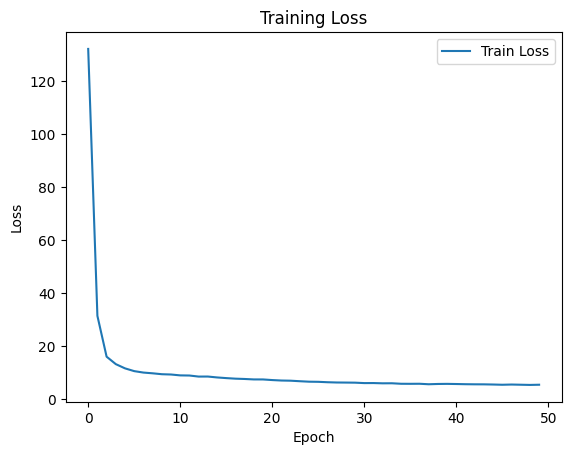

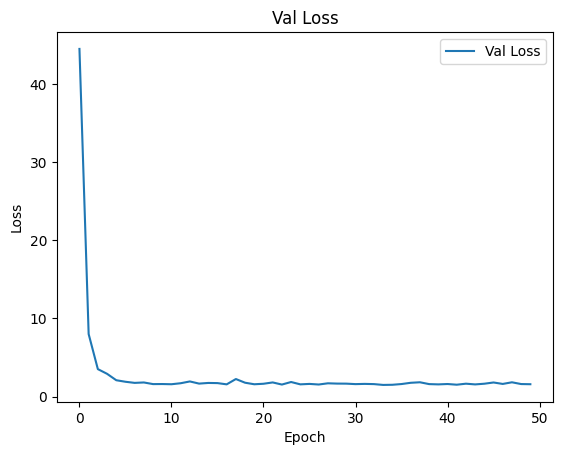

In [40]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()


plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Val Loss')
plt.legend()
plt.show()

In [42]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device
)

test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val/test dataset')
print('Val loss: ', val_loss)
print('Test loss: ', test_loss)

Evaluation on val/test dataset
Val loss:  1.577756665598427
Test loss:  1.406094193239735


In [43]:
model.eval()

sample_input = torch.tensor([[10.0, 12.0, 15.0, 14.0, 13.0, 11.0]], dtype=torch.float32).to(device)
sample_input = sample_input.unsqueeze(2)


with torch.no_grad():
    predicted_temperature = model(sample_input)
    print(f"Predicted Temperature: {predicted_temperature.item()}")

Predicted Temperature: 10.218366622924805
